# CDIPpy Example - Boxplot of Monthly-Averaged Significant Wave Height
The following example runs an application of the [CDIPpy](https://cdipsw.github.io/CDIPpy/quickstart/) python library to create plot of monthly-averaged boxes of Significant Wave Height (Hs) data across one year.
* See http://cdip.ucsd.edu/themes/cdip?pb=1&bl=cdip?pb=1&d2=p70&u3=s:093:st:1:v:hs_box_plot:dt:2011 for example Hs Boxplot.

Steps:
1) read in CDIP station metadata,
2) access wave data for time period of interest,
3) Compute metrics
4) plot boxplot,


## Import Libraries

Start by importing the necessary python packages and CDIPPY module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import calendar
import pandas as pd

# CDIP imports
from cdippy.stndata import StnData 

## Initialize CDIPpy input parameters
* Supply CDIP station id
* Start date (YYYYMMDDHH)
* End date
* Station parameters to return

In [2]:
##- Initialize station id, start/end date, and parameters
stn = '067'
sdate = '20110101'
edate = '20111231'
params = ['waveHs']

## Data Access

* Use cdippy.stndata function StnData(stn)
* Returns StnData object
* Access station metadata about individual stations deployments

### Grab data using 'get_series' function
Will return a dictionary of arrays for each parameter as keys

stn_data.get_series(start, end, params)
* start: start datetime (datetime obj)
* end: end datetime (datetime obj)
* params: list of parameters

In [3]:
##- Get Station Dataset object
stn_data = StnData(stn)

##- Get metadata (i.e. information about individual deployments)
meta = stn_data.get_stn_meta()
stn_name = meta['metaStationName']
print(stn_name)

SAN NICOLAS ISLAND, CA BUOY - 067p1


### Access data of interest
The get_series() will return a dictionary with variable names as keys

In [4]:
##- Use CDIPPY to convert input start/end date strings to datetime objects
import cdippy.utils.utils as utils
start = utils.cdip_datetime(sdate)
end = utils.cdip_datetime(edate)

##- Grab data using 'get_series' function
data = stn_data.get_series(start, end, params)
data.keys()

dict_keys(['waveHs', 'waveTime'])

## Convert waveTimes to Datetime object

In [5]:
## Convert wave times to datetime objects (currently integers)
##- Convert times to datetime objects
wT = [utils.timestamp_to_datetime(x) for x in data['waveTime']]

## Create a Pandas Dataframe indexed by time

In [6]:
## Create pandas dataframe from data
df = pd.DataFrame({'Time': wT, 'Hs': data['waveHs'].data})
df.set_index('Time', inplace=True)
# Add a "Month" column for grouping
df['Month'] = df.index.month
df['Hs']

Time
2011-01-01 00:29:07    1.51
2011-01-01 00:59:08    1.58
2011-01-01 01:29:07    1.52
2011-01-01 01:59:08    1.49
2011-01-01 02:29:08    1.50
                       ... 
2011-12-30 21:59:07    3.32
2011-12-30 22:29:07    3.36
2011-12-30 22:59:07    3.20
2011-12-30 23:29:07    3.21
2011-12-30 23:59:07    3.10
Name: Hs, Length: 16912, dtype: float32

## Group the data by month

In [7]:
# Create a pandas data frame converting timestamps to datetime objects for totals boxplot
df_totals = pd.DataFrame(
    data["waveHs"], index=pd.to_datetime(data["waveTime"], unit="s")
)
# Add fake data to create ticks for months without data
dt_waveTime = pd.to_datetime(data["waveTime"], unit="s")
months_with_data = np.unique(dt_waveTime.month)
for m in range(1, 13):
    if m not in months_with_data:
        new_dt = datetime(year, m, 1)
        uts = time.mktime(new_dt.timetuple())
        data["waveTime"] = np.ma.append(data["waveTime"], uts)
        data["waveHs"] = np.ma.append(data["waveHs"], 0.0)

# Create a pandas data frame for month boxplots (with fake data)
df_months = pd.DataFrame(data["waveHs"], index=pd.to_datetime(data["waveTime"], unit="s"))

# Group the data by month
#grp = pd.groupby(df_months, by=[df_months.index.month])

grp = df_months.groupby(by=[df_months.index.month])

### Set figure defaults

In [8]:
# Figure defaults
aspect_ratio = 1.3  # x/y
default_x_inch = 8
default_ylim_top = 8

# Colors
flier_color = (0.35, 0.35, 1)  # R,G,B tuple
mean_color = "green"
median_color = "red"
box_color = "0.5"  # A shade of gray

# Font defaults
default_title_font = 15
default_subtitle_font = 12
default_label_font = 9
default_annotate_font = 8

# Calculate the figure size based on x_inch
x_inch = default_x_inch
x_inch = int(x_inch)
y_inch = x_inch / aspect_ratio

# Scale the fonts
font_scale = x_inch / default_x_inch

title_font_size = round(font_scale * default_title_font, 0)
subtitle_font_size = round(font_scale * default_subtitle_font, 0)
label_font_size = round(font_scale * default_label_font, 0)
annotate_font_size = round(font_scale * default_annotate_font, 0)

# Second Hs scale
def ft_to_m(Dm):
    return 3.28084 * Dm

Text(0, 0.5, 'Hs (ft)')

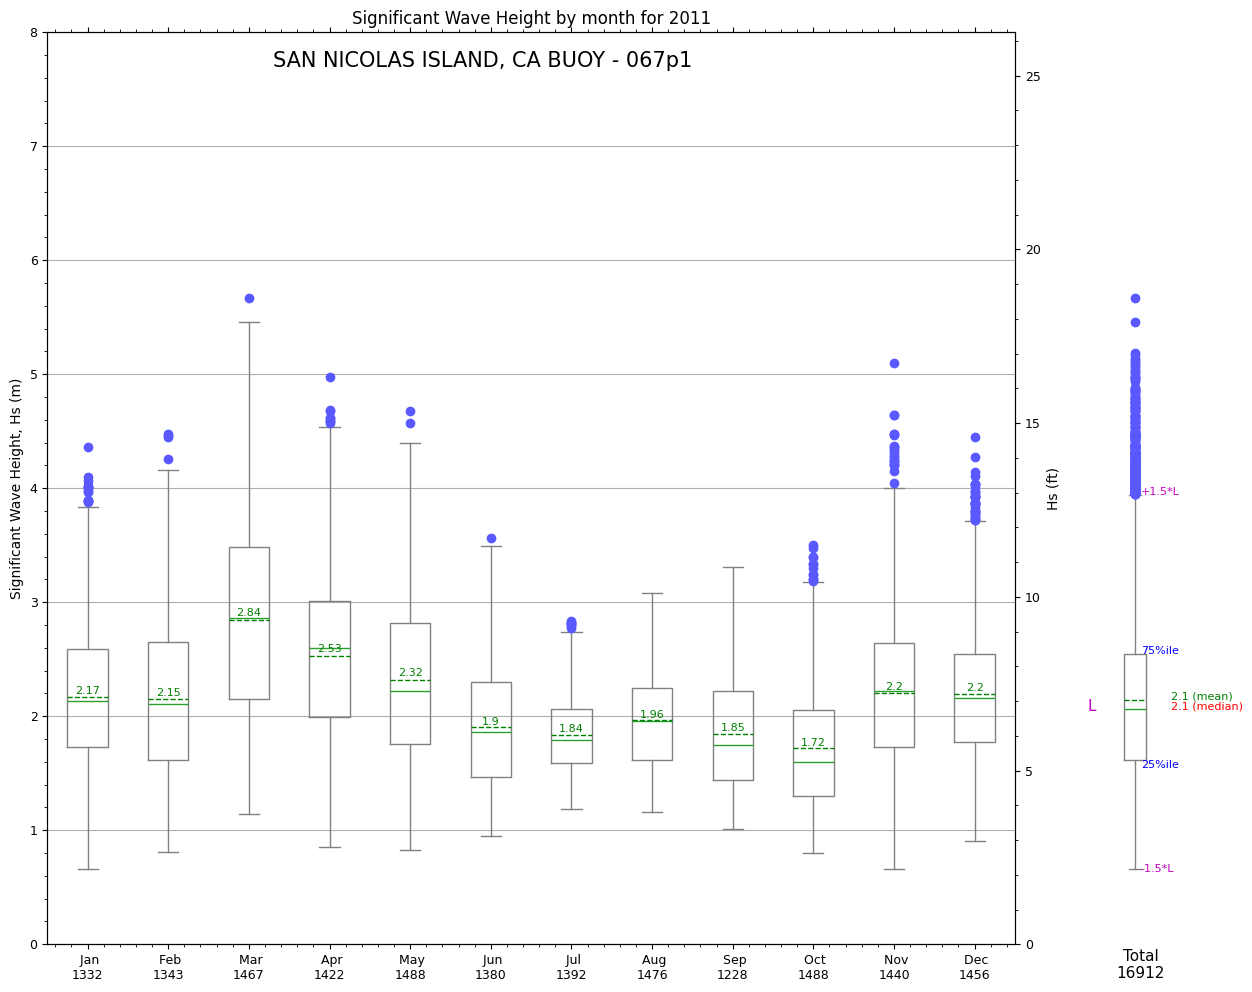

In [9]:
# Create figure and specify figure size
fig = plt.figure(figsize=(15,12))

# This pushes the axes down so the buoy title can be prominent
fig.subplots_adjust(top=0.87)

# Use grid spec to define a 30 column grid. Total boxplot uses 4 columns
ax = plt.subplot2grid((1, 30), (0, 0), colspan=25)
ax2 = plt.subplot2grid((1, 30), (0, 26), colspan=4)

# Create another axes for Hs in feet
ax_feet = ax.twinx()
ax_feet.set_ylabel("Hs (ft)", fontsize=label_font_size + 1)

# Get ylim top and set axes ylims
ylim_top = max(default_ylim_top, max(data["waveHs"]))  # meters
ylim = (0, int(ylim_top))
ax.set_ylim(ylim)
ax_feet.set_ylim(ft_to_m(ylim[0]), ft_to_m(ylim[1]))
ax2.set_ylim(ylim)

# Create months boxplot using axes ax. Subplots=False plots on a single axes on the current figure
(ax, bp_dict) = grp.boxplot(
    return_type="both",
    subplots=False,
    showmeans=True,
    meanline=True,
    whiskerprops={"linestyle": "solid"},
    ax=ax,
)

# Set colors
# Could use plt.setp(bp_dict['caps'], color=box_color)
[
    x.set(markeredgecolor=flier_color, markerfacecolor=flier_color)
    for x in bp_dict["fliers"]
]
[x.set(color=box_color) for x in bp_dict["caps"]]
[x.set(color=box_color) for x in bp_dict["whiskers"]]
[x.set(color=box_color) for x in bp_dict["boxes"]]

# Turn off vertical grid
ax.xaxis.grid(False)

# Turn on minor ticks for both y axes. Feels kludgey using plt.sca (set current axes)
plt.sca(ax)
plt.minorticks_on()
plt.sca(ax_feet)
plt.minorticks_on()

# Turn off unwanted ticks. Could also set labelsize here
ax.tick_params(axis="x", which="minor", bottom="off", top="off")
ax.tick_params(axis="x", which="major", top="off")
ax_feet.tick_params(axis="x", which="minor", bottom="off", top="off")

# Loop through months, set colors, avg, x labels and counts
counts = grp.count()
labels = []
total_records = 0
for m in range(1, 13):
    if m in months_with_data:
        mn = bp_dict["means"][m - 1]
        mn.set(color=mean_color)
        x = mn.get_xdata()
        y = mn.get_ydata()
        xy = ((x[0] + x[1]) / 2, y[0] * (1 + 0.1 / ylim[1]))
        # Annotate means
        ax.annotate(
            str(round(y[0], 2)),
            xy=xy,
            color=mean_color,
            ha="center",
            fontsize=annotate_font_size,
        )
        # Create labels w/ record counts
        labels.append(" " + calendar.month_abbr[m] + "\n" + str(counts[0][m]))
        total_records += counts[0][m]
    else:
        labels.append(" " + calendar.month_abbr[m] + "\n" + "0")
ax.set_xticklabels(labels, fontsize=label_font_size)

# Adjust yticklabel font size
plt.setp(ax.get_yticklabels(), fontsize=label_font_size)
plt.setp(ax_feet.get_yticklabels(), fontsize=label_font_size)

# Create subplot of totals for the year
(ax2, bp_dict) = df_totals.boxplot(
    return_type="both",
    showmeans=True,
    meanline=True,
    whiskerprops={"linestyle": "solid"},
    ax=ax2,
)

# Set colors
bp_dict["means"][-1].set(color=mean_color)
[
    x.set(markeredgecolor=flier_color, markerfacecolor=flier_color)
    for x in bp_dict["fliers"]
]
[x.set(color=box_color) for x in bp_dict["caps"]]
[x.set(color=box_color) for x in bp_dict["whiskers"]]
[x.set(color=box_color) for x in bp_dict["boxes"]]

# Turn off the axis
plt.sca(ax2)
plt.axis("off")


# Get x,y coordinates for totals annotations
x = bp_dict["caps"][0].get_xdata()[1]
cap_lower_y = bp_dict["caps"][0].get_ydata()[0]
cap_upper_y = bp_dict["caps"][1].get_ydata()[0]
whisker_lower_y = bp_dict["whiskers"][0].get_ydata()[0]
whisker_upper_y = bp_dict["whiskers"][1].get_ydata()[0]
median_y = bp_dict["medians"][0].get_ydata()[0]
mean_y = bp_dict["means"][0].get_ydata()[0]
whisker_avg = (whisker_upper_y + whisker_lower_y) / 2.0

# Make the annotations
ax2.annotate(
    "-1.5*L",
    xy=(x, cap_lower_y),
    color="m",
    fontsize=annotate_font_size,
     va="center",
)
ax2.annotate("+1.5*L", xy=(x, cap_upper_y), color="m", fontsize=annotate_font_size)
ax2.annotate(
    "25%ile",
    xy=(x, whisker_lower_y),
    color="blue",
    fontsize=annotate_font_size,
    va="top",
)
ax2.annotate(
    "75%ile", xy=(x, whisker_upper_y), color="blue", fontsize=annotate_font_size
)
ax2.annotate(
    str(round(median_y, 1)) + " (median)",
    xy=(x + 0.2, median_y),
    color=median_color,
    fontsize=annotate_font_size,
)
ax2.annotate(
    str(round(mean_y, 1)) + " (mean)",
    xy=(x + 0.2, mean_y),
    color=mean_color,
    fontsize=annotate_font_size,
)
ax2.annotate(
    "L",
    xy=(x - 0.3, whisker_avg),
    color="m",
    fontsize=subtitle_font_size - 1,
    ha="right",
    va="center",
)
ax2.annotate(
    "Total" + "\n" + str(total_records),
    xy=(x, 0),
    xytext=(x, -0.3 / ylim[1]),
    color="k",
    fontsize=subtitle_font_size - 1,
    ha="center",
    va="top",
)

# Add the title and suptitle, adjust a little to the left to center over months boxplot axes
plt.suptitle(stn_name, fontsize=title_font_size, transform=ax.transAxes, x=0.45)
ax.set_title(
    "Significant Wave Height by month for " + str(start.year), fontsize=subtitle_font_size
)

# Adjust ylabel font size
ax.set_ylabel("Significant Wave Height, Hs (m)", fontsize=label_font_size + 1)
ax_feet.set_ylabel("Hs (ft)", fontsize=label_font_size + 1)
